## 1. Importación de librerías y cargar datos

### 1.1. Importación de librerías

Usando el archivo requeriments.txt y el comando ``pip install -r <file.txt>`` se instalan las librerías necesarias

In [1]:
# Librerias para el modelo
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications import ResNet50V2

# Otros
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
import os
import cv2
import seaborn as sns
from Data_Paths import *

### 1.2. Image Data Generators

#### Cargar las imagenes desde la carpeta ``images``

Creamos los generadores de imagenes con el reescalado para entrenamiento, validación y test. Estos generadores cuentan con varios filtros para realizar el preprocesado de las imágenes antes de entroducirlas en la CNN

In [2]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest',
)

test_datagen = ImageDataGenerator(
  rescale=1./255, 
)

val_datagen = ImageDataGenerator(
  rescale=1./255,
)

Cargamos las imagenes del directorio a traves de los generadores de imagenes, y observamos cuantas imágene  
hay para entrenamiento, validación y test

In [3]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DATASET,
    target_size = (220, 220),
    color_mode="rgb",
    batch_size = 16,
    shuffle=True,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        TEST_DATASET,
        target_size = (220, 220),
        color_mode="rgb",
        batch_size = 8,
        shuffle=True,
        class_mode = 'binary'
)
test_generator = test_datagen.flow_from_directory(
    VAL_DATASET,
    shuffle = False,
    target_size = (220, 220),
    color_mode="rgb",
    batch_size = 32,
    class_mode = 'binary'
)

Found 2160 images belonging to 2 classes.
Found 270 images belonging to 2 classes.
Found 270 images belonging to 2 classes.


Crear un directorio para almacenar los resultados del entrenamiento

In [4]:
# si ya está creado comentar estas líneas para trabajar
# os.mkdir('./logs')
# os.mkdir('./logs/fit')

## 2. ResNet Model Architecture:

Parámetros de la arquitectura ResNet que vamos a utilizar

In [5]:
input_shape = (220, 220, 3)

# Cargamos el modelo pre-entrenado
base_model = ResNet50V2(weights = 'imagenet',
                        input_shape = input_shape,
                        include_top = False)

for layer in base_model.layers:
    layer.trainable = False
    
# Añadimos nuevas capas
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model and new layers into a single model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy"])

Entrenamiento del modelo

In [6]:
CHECKPOINT_PATH = os.path.join(MODEL_DATASET, 'real_fake_classification.weights.h5')

# Create checkpoint callback.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH,
                                      save_weights_only = True,
                                      monitor = "val_accuracy",
                                      save_best_only = True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs.
# If val loss decreases for 5 epochs, stop training.
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                            mode = "min",
                                            patience = 5, 
                                            restore_best_weights = True)

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = len(train_generator)//16,
                    epochs = 50,
                    callbacks=[checkpoint_callback, callback])

Epoch 1/50


c:\Users\vssta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.4396 - loss: 1.0084 - val_accuracy: 0.5667 - val_loss: 0.7134
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5866 - loss: 0.6732 - val_accuracy: 0.6148 - val_loss: 0.6847
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6431 - loss: 0.6308 - val_accuracy: 0.6259 - val_loss: 0.6876
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6470 - loss: 0.6672 - val_accuracy: 0.6481 - val_loss: 0.6570
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6612 - loss: 0.6716 - val_accuracy: 0.6185 - val_loss: 0.6728
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.7177 - loss: 0.5852 - val_accuracy: 0.6667 - val_loss: 0.6178
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6111 - loss: 0.7172 - val_accuracy: 0.6185 - val_loss: 0.6305
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6765 - loss: 0.6221 - val_accuracy: 0.6963 - val_loss: 0.6253
Epoch 9/50
8/8 ━━━━

c:\Users\vssta\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6737 - loss: 0.6343 - val_accuracy: 0.6037 - val_loss: 0.6726
Epoch 18/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6392 - loss: 0.6461 - val_accuracy: 0.6852 - val_loss: 0.6001


Creamos el archivo donde se guardará el modelo una vez entrenado, y guardamos dicho modelo

In [7]:
MODEL_DATAPATH = os.path.join(MODEL_DATASET, 'real_fake_classification.h5')

# Save the entire model
model.save(MODEL_DATAPATH, overwrite=True)

Guardamos los valores de accuracy y loss a lo largo del entrenamiento y la validación

In [8]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Imprimimos dichos valores en dos gráficas respecto a las epoch

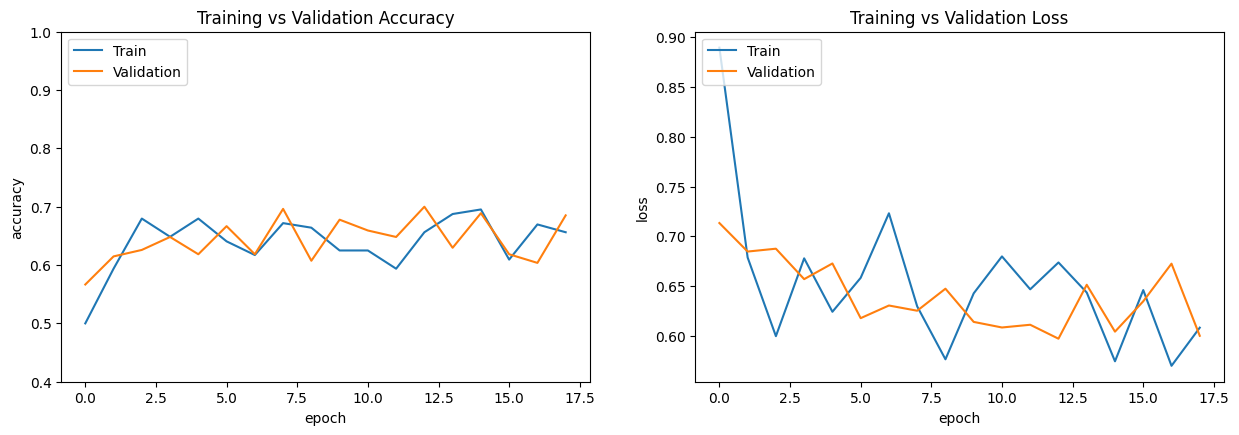

In [9]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

## 3. Resultados del entrenamiento

Cargamos el modelo guardado para observar los resultados

In [10]:
loaded_model = load_model(MODEL_DATAPATH)

Realizamos las predicciones con los datos de test

In [11]:
pred = loaded_model.predict(test_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step


In [12]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

y_pred

[0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,


In [13]:
# Take the true information of the test data.
y_true = test_generator.classes

y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

Mostramos los resultados de las predicciones en una matriz de confusión

In [14]:
cm = confusion_matrix(y_true, y_pred)

Text(50.722222222222214, 0.5, 'Truth')

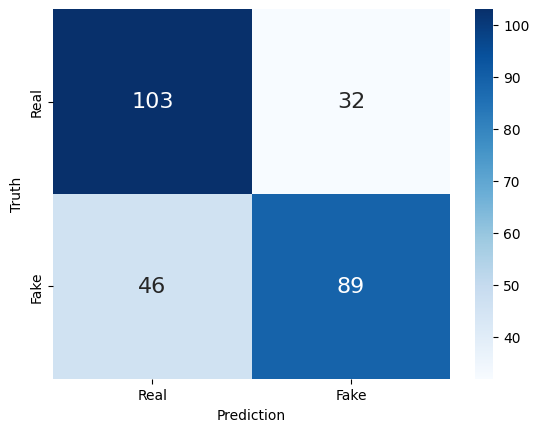

In [15]:
# Define the class names.
class_names = ['Real', 'Fake']

# Create the heatmap with class names as tick labels.
ax = sns.heatmap(cm, annot = True, fmt = '.0f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

# Set the axis labels.
ax.set_xlabel("Prediction")
ax.set_ylabel("Truth")

Imprimimos las métricas generales de rendimiento del modelo

In [16]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.76      0.73       135
           1       0.74      0.66      0.70       135

    accuracy                           0.71       270
   macro avg       0.71      0.71      0.71       270
weighted avg       0.71      0.71      0.71       270



Falsos positivos y Falsos negativos

In [17]:
# Classify the test data cases into true negative, true positive, false positive,
# and false negative cases.
confusion = []

for i, j in zip(y_true, y_pred):
  if i == 0 and j == 0:
    confusion.append('TN')
  elif i == 1 and j == 1:
    confusion.append('TP')
  elif i == 0 and j == 1:
    confusion.append('FP')
  else:
    confusion.append('FN')

In [18]:
confusion_table = pd.DataFrame(data = confusion, columns = ["Results"])
confusion_table

,Results
0,TN
1,TN
2,FP
3,FP
4,TN
...,...
265,FN
266,TP
267,TP
268,TP


In [19]:
# Create a table with prediction, truth, and results.
confusion_table = pd.DataFrame({'Predicton':y_pred,
                                'Truth': y_true,
                                'Results': confusion})
confusion_table

,Predicton,Truth,Results
0,0,0,TN
1,0,0,TN
2,1,0,FP
3,1,0,FP
4,0,0,TN
...,...,...,...
265,0,1,FN
266,1,1,TP
267,1,1,TP
268,1,1,TP


In [20]:
FPs = confusion_table[confusion_table['Results'] == 'FP']
FPs

,Predicton,Truth,Results
2,1,0,FP
3,1,0,FP
11,1,0,FP
13,1,0,FP
14,1,0,FP
18,1,0,FP
20,1,0,FP
23,1,0,FP
32,1,0,FP
34,1,0,FP


In [21]:
FNs = confusion_table[confusion_table['Results'] == 'FN']
FNs

,Predicton,Truth,Results
141,0,1,FN
142,0,1,FN
146,0,1,FN
147,0,1,FN
152,0,1,FN
154,0,1,FN
158,0,1,FN
167,0,1,FN
168,0,1,FN
169,0,1,FN


In [22]:
real_test_images = glob.glob(VAL_DATASET + "/real/*.jpg")
fake_test_images = glob.glob(VAL_DATASET + "/fake/*.jpg")

In [34]:
import random

2


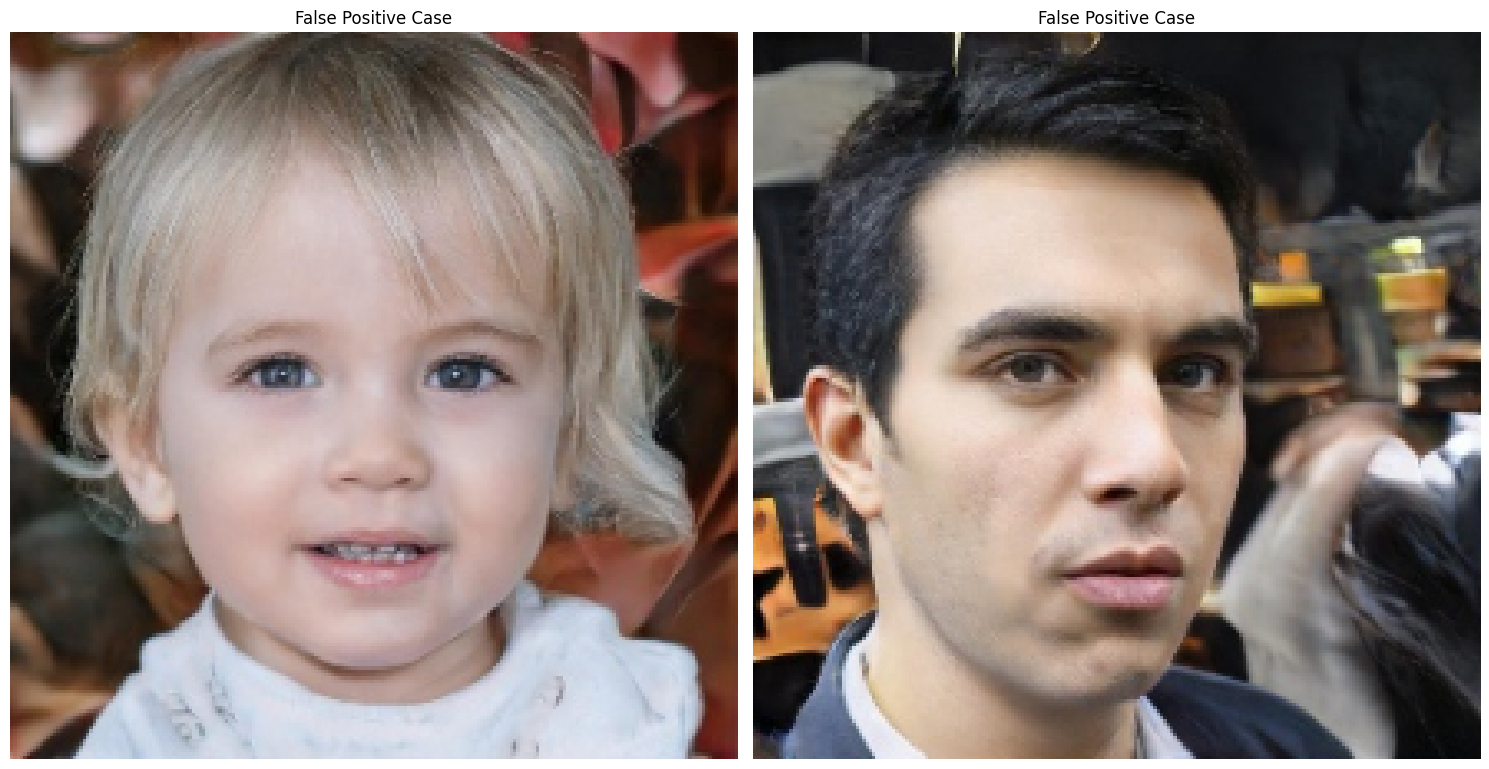

In [57]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
# Creamos una lista para almacenar las imágenes
images = []

for i, ax in zip(FPs.index, axes.flat):
    img = cv2.imread(fake_test_images[i], cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (220, 220))
    # Agregamos la imagen original 
    images.append(img)
    ax.set_title("False Positive Case")

print(len(images))

# Mostramos las imágenes con su tamaño
for i, img in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

# Ajustamos el diseño de la figura
plt.tight_layout()
plt.show()

8


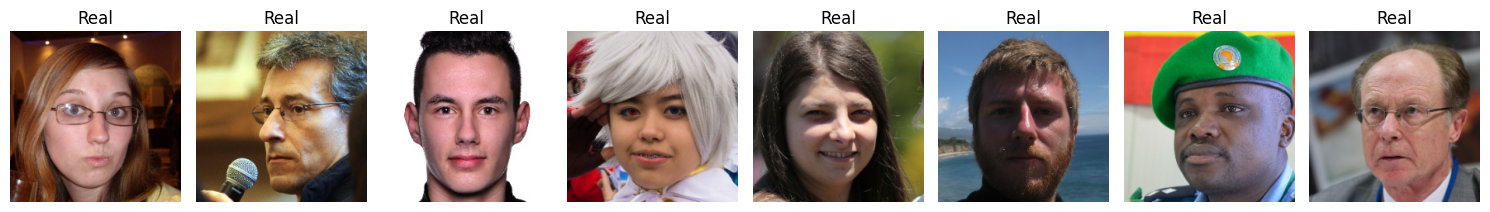

In [59]:
fig, axes = plt.subplots(nrows = 1, ncols = 8, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
# Creamos una lista para almacenar las imágenes
images = []

for i, ax in zip(FPs.index, axes.flat):
    img = cv2.imread(real_test_images[i], cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (220, 220))
    # Agregamos la imagen original 
    images.append(img)
    ax.set_title("Real")

print(len(images))

# Mostramos las imágenes con su tamaño
for i, img in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

# Ajustamos el diseño de la figura
plt.tight_layout()
plt.show()

8


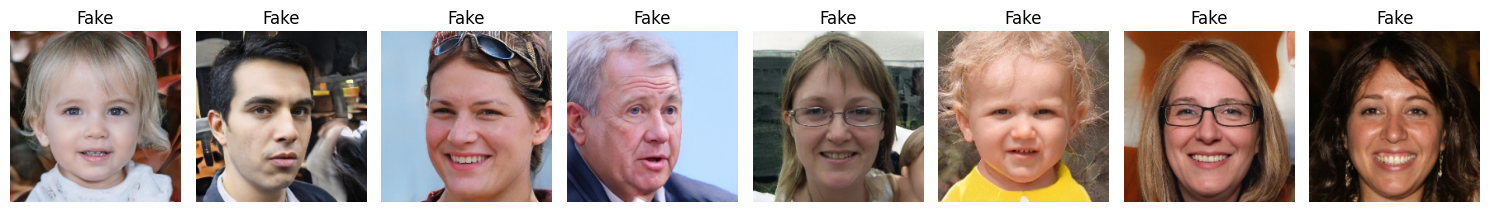

In [60]:
fig, axes = plt.subplots(nrows = 1, ncols = 8, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
# Creamos una lista para almacenar las imágenes
images = []

for i, ax in zip(FPs.index, axes.flat):
    img = cv2.imread(fake_test_images[i], cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (220, 220))
    # Agregamos la imagen original 
    images.append(img)
    ax.set_title("Fake")

print(len(images))

# Mostramos las imágenes con su tamaño
for i, img in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

# Ajustamos el diseño de la figura
plt.tight_layout()
plt.show()